# OL\* vs L\*

We will compare the L\* algorithm by Angluin (1987) with our new OL\* algorithm, which decomposes a Mealy machine into components, where each components models the behaviour of the SUL for a single output.

We ran both OL\* and L\* on the benchmarks from Labbaf et al. (2023). This benchmark consists of the parallel interleaving of multiple smaller automata. Note that the components of these machines can be split by their input alphabet, but not necessarily by their output alphabet. Some outputs are unique for a component, and can thus by learned efficiently by OL\*, while others appear in multiple components (like the output **1**), so these will be tricky for OL\* to learn.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme("paper")

data_olstar = pd.read_csv("..\\..\\results\\results_labbaf_olstar.csv")
data_lstar = pd.read_csv("..\\..\\results\\results_labbaf_lstar.csv")

data_olstar.sum()

Model                      19418
Stages                       211
States                    148781
Short rows                111403
Inconsistent count          3222
Zero outputs count             0
Two outputs count              0
Learning queries       130217898
Learning symbols      1795750786
Testing queries             1714
Testing symbols            33847
dtype: int64

In [2]:
data_olstar[data_olstar["Testing queries"] > 0]

,Model,Stages,States,Short rows,Inconsistent count,Zero outputs count,Two outputs count,Learning queries,Learning symbols,Testing queries,Testing symbols
32,33,3,26,26,0,0,0,6953,49992,65,1127
33,34,2,26,26,0,0,0,6064,41566,4,100
60,61,2,96,96,0,0,0,35135,319645,29,496
67,68,3,117,117,18,0,0,104551,889963,29,535
132,134,3,832,832,0,0,0,893780,10554291,390,7436
154,156,3,1248,1248,0,0,0,1616674,27066340,71,1447
163,165,3,1664,1664,21,0,0,2933492,34468067,262,5170
183,185,3,2496,2496,17,0,0,4151298,49461108,559,11403
188,191,2,3328,3328,18,0,0,4545438,55709058,305,6133


In [3]:
data_lstar[data_lstar["Testing queries"] > 0]

,Model,Stages,States,Learning queries,Learning symbols,Testing queries,Testing symbols
32,33,3,26,5990,39468,49,695
33,34,3,26,6827,48869,107,1731
43,44,3,39,12731,95055,32,487
58,59,3,78,23109,153696,69,1209
60,61,3,96,28834,206551,29,573
67,68,3,117,49477,341924,320,5692
73,74,3,144,50839,376787,109,1918
97,99,3,384,246932,2909971,183,3288
118,120,3,576,302695,2581661,108,2108
119,121,3,576,538258,7344909,94,1797


> Note: All testing queries for OL\* come from only 8 models. In contrast, L\* needs testing queries for 37 models.

We will first analyse the performance of OL\* against the performance of L\*.

In [4]:
print("OL* Learning:", f"{data_olstar["Learning queries"].mean():_.2f}")
print("L* Learning: ", f"{data_lstar["Learning queries"].mean():_.2f}")

OL* Learning: 664_377.03
L* Learning:  450_177.75


In [5]:
print("OL* Testing:", f"{data_olstar["Testing queries"].mean():_.2f}")
print("L* Testing:", f"{data_lstar["Testing queries"].mean():_.2f}")

OL* Testing: 8.74
L* Testing: 29.82


In [6]:
def total_queries(df):
    return df["Learning queries"] + df["Testing queries"]

def total_symbols(df):
    return df["Learning symbols"] + df["Testing symbols"]

print("OL* Total:", f"{total_symbols(data_olstar).median():_.2f}")
print("L* Total: ", f"{total_symbols(data_lstar).median():_.2f}")

OL* Total: 892_192.00
L* Total:  777_234.00


When looking at just the number of learning queries, L\* outperforms OL\*. However, OL\* more than makes up for this with the number of testing queries needed.

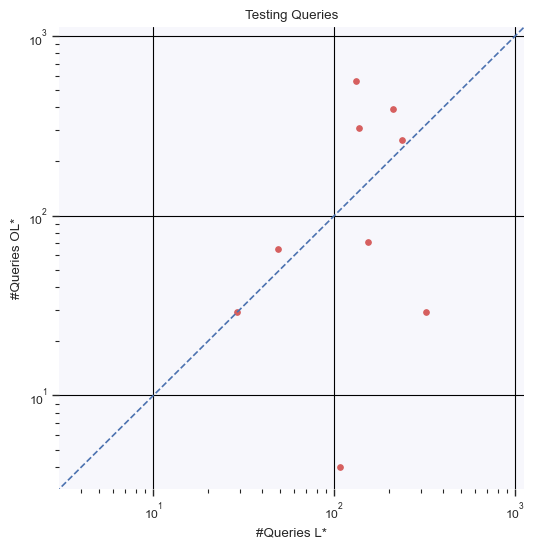

In [7]:
def plot_queries(df_lstar, df_olstar, data="Queries"):
    queries_lstar  = df_lstar["Testing queries"] #total_queries(df_lstar) if data == "Queries" else total_symbols(df_lstar)
    queries_olstar = df_olstar["Testing queries"] #total_queries(df_olstar) if data == "Queries" else total_symbols(df_olstar)

    plt.figure(figsize=(6,6))

    plt.scatter(queries_lstar, queries_olstar, color=sns.color_palette("muted")[3], s=16)
    max_queries = max(queries_lstar.max(), queries_olstar.max())
    xy = np.linspace(0, max_queries*2, 100)
    plt.plot(xy, xy, 'b--')
    plt.xscale("log")
    plt.yscale("log")
    min_lim = min(plt.xlim()[0], plt.ylim()[0])
    plt.xlim(min_lim, max_queries*2)
    plt.ylim(min_lim, max_queries*2)

    plt.xlabel("#" + data + " L*")
    plt.ylabel("#" + data + " OL*")
    plt.title("Testing " + data)
    ax = plt.gca()
    ax.set_facecolor((0.97, 0.97, 0.99))
    ax.grid(axis="both", color="black")

    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tick_params(which="both", bottom=True, left=True)
    plt.show()

plot_queries(data_lstar, data_olstar, data="Queries")

## Testing queries

Many models do not require any equivalence queries to learn correctly (ignoring the last equivalence query which returns "true"). From initial testing, OL\* seemed to have a big advantage for models that _do_ require equivalence queries. It requires fewer equivalence queries, which results in fewer testing queries. We will now analyse how big the advantage of OL\* is for these models.

In [8]:
tq_olstar = data_olstar[data_lstar["Testing queries"] > 0]
tq_lstar = data_lstar[data_lstar["Testing queries"] > 0]

print(f"{total_queries(tq_olstar).mean():_.2f}")
print(f"{total_queries(tq_lstar).mean():_.2f}")

1_791_459.27
883_825.97


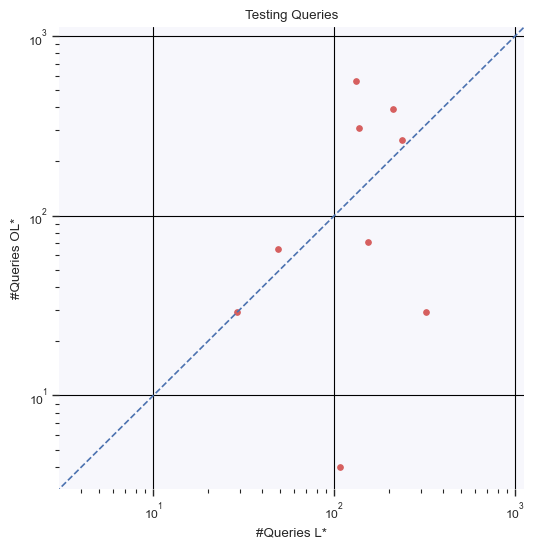

In [9]:
plot_queries(tq_lstar, tq_olstar)

Conlusion: From the plot, it seems like the hypothesis is true. Filtering for SULs where L\* needed at least one equivalence query to find the correct model shows that OL\* does better than L\*. Did we give OL\* an unfair advantage by filtering this way?

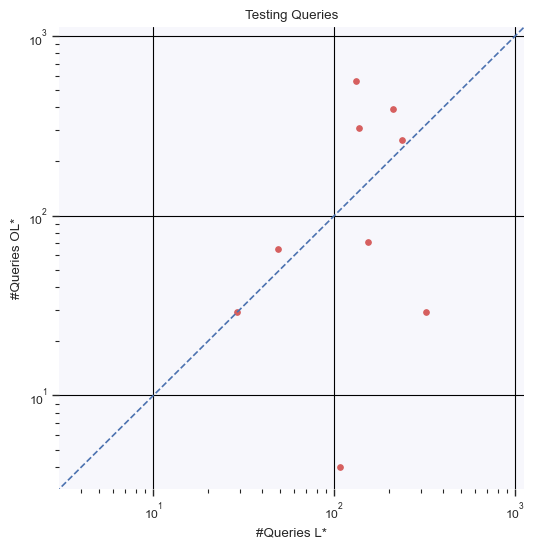

In [10]:
tq2_olstar = data_olstar[data_olstar["Testing queries"] > 0]
tq2_lstar = data_lstar[data_olstar["Testing queries"] > 0]

plot_queries(tq2_lstar, tq2_olstar)

For the 8 models where OL\* needs at least one equivalence query, the performance of OL\* and L\* seems similar. Important for this is that there are no SULs where OL\* needs to do an equivalence query while L\* does not need one. However, this benchmark set is too small make any definitive conclusions on which algorithm does better.

> Note: The bottom left data point is actually 2 points, which is why we count only 7 red dots in the graph.

## Short prefix rows

The main benefit of using OL\* is that it can decompose a full machine into smaller components, where each component models the behaviour for one output symbol. However, some models cannot be decomposed: the smallest component has as many states as the full machine. The number of states of components is reflected in the number of short prefix rows in the table during learning.

In this section, we will analyse the two possible scenarios: the number of short prefix rows needed by OL\* is smaller than the number of states of the SUL, and the number of short prefix rows needed by OL\* is equal to the number of states of the SUL. Note that it is impossible for OL\* to require more short prefix rows that there are states in the SUL, since we only add a short prefix row when there is an output for which this row differs from all previous rows, and the number of unique rows is precisely the number states of the SUL.

#### Short prefix rows < Number of states

We will start our analysis by looking at the scenario in which OL\* needs fewer short prefix rows than the number of states in the SUL. Our hypothesis would be that OL\* would then need fewer queries than L\*, since the model has been effectively decomposed into smaller components.

In [11]:
short_olstar = data_olstar[data_olstar["Short rows"] < data_olstar["States"]]
short_lstar = data_lstar[data_olstar["Short rows"] < data_olstar["States"]]

print(f"{total_symbols(short_olstar).mean():_.2f}")
print(f"{total_symbols(short_lstar).mean():_.2f}")

11_503_930.27
4_606_877.76


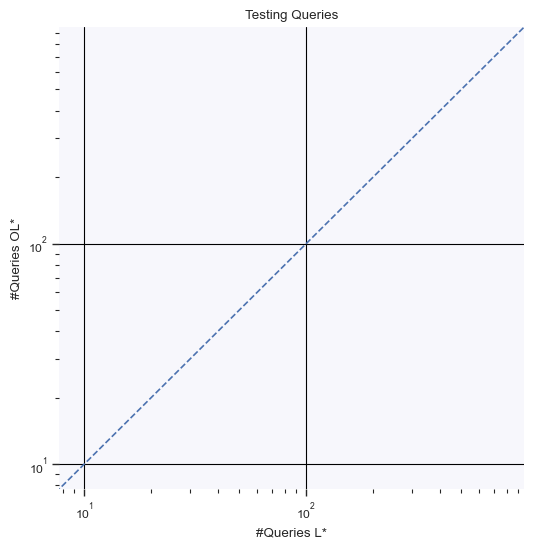

In [12]:
plot_queries(short_lstar, short_olstar, data="Queries")

#### Short prefix rows = Number of states

When the number of short prefix rows needed by OL\* is equal to the number of states of the SUL, we would expect OL\* to either do similar to L\*, since the algorithm reduces to doing L\*, or to do worse, since it would require some extra queries to realise that the smallest component is the full SUL.

In [13]:
equal_olstar = data_olstar[data_olstar["Short rows"] == data_olstar["States"]]
equal_lstar = data_lstar[data_olstar["Short rows"] == data_olstar["States"]]

print(f"{total_queries(equal_olstar).mean():_.2f}")
print(f"{total_queries(equal_lstar).mean():_.2f}")

519_708.38
355_555.77


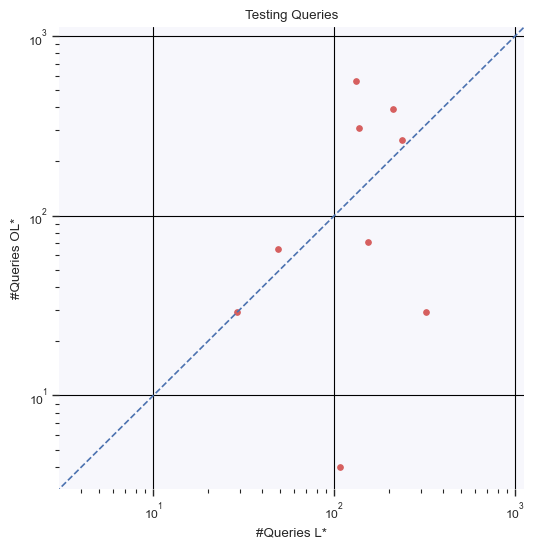

In [14]:
plot_queries(equal_lstar, equal_olstar)

# Comparison based on the size of the SUL

In the paper by Labbaf et al. (2023), they split up the SULs into groups based on the number of states. What do our results look like if we split up the SULs into groups in the same way? The groups used by Labbaf et al. (2023) were the following:
- $\leq$ 600
- (600, 900]
- (900, 1200]
- (1200, 1500]
- (1500, 1800]
- (1800, 2100]
- (2100, 2400]
- $>$ 2400

> Note: Labbaf et al. (2023) also throw away data points with less than 300 states (93 models) or more than 3840 states (4 models)

In [15]:
bins = [0, 600, 900, 1200, 1500, 1800, 2100, 2400, 4860]

combined = pd.concat([data_lstar["States"], total_queries(data_lstar), total_queries(data_olstar)], axis=1)
combined.columns = ["States", "L*", "OL*"]
combined["State range"] = pd.cut(combined["States"], bins=bins)
combined = combined.set_index("State range")
combined = combined[["L*", "OL*"]].stack().reset_index()
combined = combined.rename(columns={"level_1": "Algorithm", 0: "#Queries"})

ranges = [combined["State range"][0], combined["State range"][244], combined["State range"][280], combined["State range"][306], combined["State range"][320], combined["State range"][342], combined["State range"][350], combined["State range"][360]]
print("Number of models for each range:", [len(combined[combined["State range"] == range]) // 2 for range in ranges])

Number of models for each range: [122, 18, 13, 7, 10, 5, 5, 16]


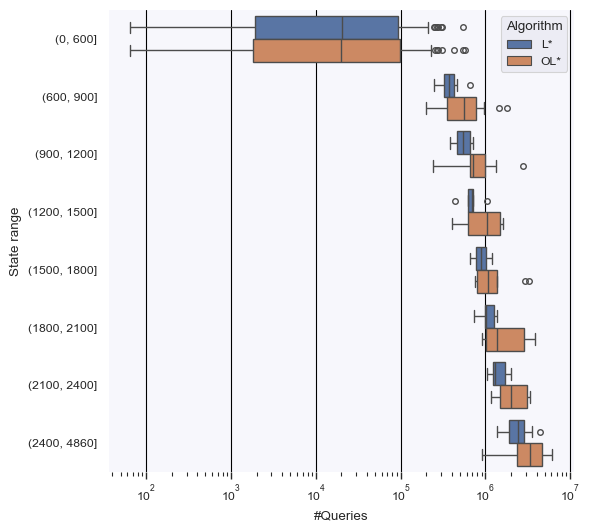

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
g1 = sns.boxplot(x = combined["#Queries"],
    y = combined["State range"],
    hue = combined["Algorithm"],
    showcaps=True, orient="h", fliersize=4)
g1.set_xscale("log")
ax = plt.gca()
ax.grid(axis="x", color="black")
ax.set_facecolor((0.97, 0.97, 0.99))
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tick_params(which="both", bottom=True)
plt.show()